In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense, LeakyReLU, BatchNormalization
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img
import os
import glob
from tqdm import tqdm

In [3]:
import os
import glob
import shutil
import numpy as np

# Define your base path and new directory path
BASE_PATH = "images"
NEW_DIRECTORY_PATH = "images_selected"

# Define your labels and image names
imageNames = [os.path.basename(file) for file in glob.glob(os.path.join(BASE_PATH, '*.jpg'))]
labels = [' '.join(name.split('_')[:-1]) for name in imageNames]

# Select 5 random labels
random_labels = np.random.choice(np.unique(labels), 5, replace=False)

# Create the new directory if it doesn't exist
if not os.path.exists(NEW_DIRECTORY_PATH):
    os.makedirs(NEW_DIRECTORY_PATH)

# Move images corresponding to the selected labels to the new directory
for label in random_labels:
    images_to_move = [file for file, lbl in zip(imageNames, labels) if lbl == label]
    for image in images_to_move:
        shutil.move(os.path.join(BASE_PATH, image), os.path.join(NEW_DIRECTORY_PATH, image))

In [4]:
imageNames = [os.path.basename(file) for file in glob.glob(os.path.join(NEW_DIRECTORY_PATH, '*.jpg'))]

print(f"\nTotal number of image files: {len(imageNames)}")


Total number of image files: 1000


In [5]:
labels = [' '.join(name.split('_')[:-1]) for name in imageNames ]

print(f"\nTotal number of unique labels: {len(np.unique(labels))}")


Total number of unique labels: 5


In [6]:
labelEncDict = {name : ind for ind, name in enumerate(np.unique(labels))}
for k, v in labelEncDict.items():
    print(f"{k:32} : {v}")

Ragdoll                          : 0
german shorthaired               : 1
havanese                         : 2
miniature pinscher               : 3
wheaten terrier                  : 4


In [7]:
labelDecDict = {ind: name for name, ind in labelEncDict.items()}
for k, v in labelDecDict.items():
    print(f"{k:3} : {v}")

  0 : Ragdoll
  1 : german shorthaired
  2 : havanese
  3 : miniature pinscher
  4 : wheaten terrier


In [8]:
for i in labelEncDict.keys():
    print(f"{i:32} : {labels.count(i)}")

Ragdoll                          : 200
german shorthaired               : 200
havanese                         : 200
miniature pinscher               : 200
wheaten terrier                  : 200


In [9]:
BASE_PATH = "images"
IMAGE_SIZE = (256, 256)
RANDOM_STATE = 7
TRAIN_SIZE, VAL_SIZE, TEST_SIZE = 0.8, 0.1, 0.1

In [10]:
imageData = []

for name in tqdm(imageNames, desc = 'Loading image data', unit = ' images'):
    img = load_img(os.path.join(NEW_DIRECTORY_PATH, name))
    img = tf.image.resize_with_pad(img_to_array(img, dtype = 'uint8'), *IMAGE_SIZE).numpy().astype('uint8')
    imageData.append(img)
    
imageData = np.array(imageData)
imageData.shape

Loading image data: 100%|██████████| 1000/1000 [00:10<00:00, 94.48 images/s]


(1000, 256, 256, 3)

In [11]:
labelsEncoded = list(map(lambda x : labelEncDict.get(x), labels))

for i, l in zip(imageNames[::1000], labelsEncoded[::1000]):
    print(f"{i:32}\t{labelDecDict[l]:32}\t{l}")

german_shorthaired_1.jpg        	german shorthaired              	1


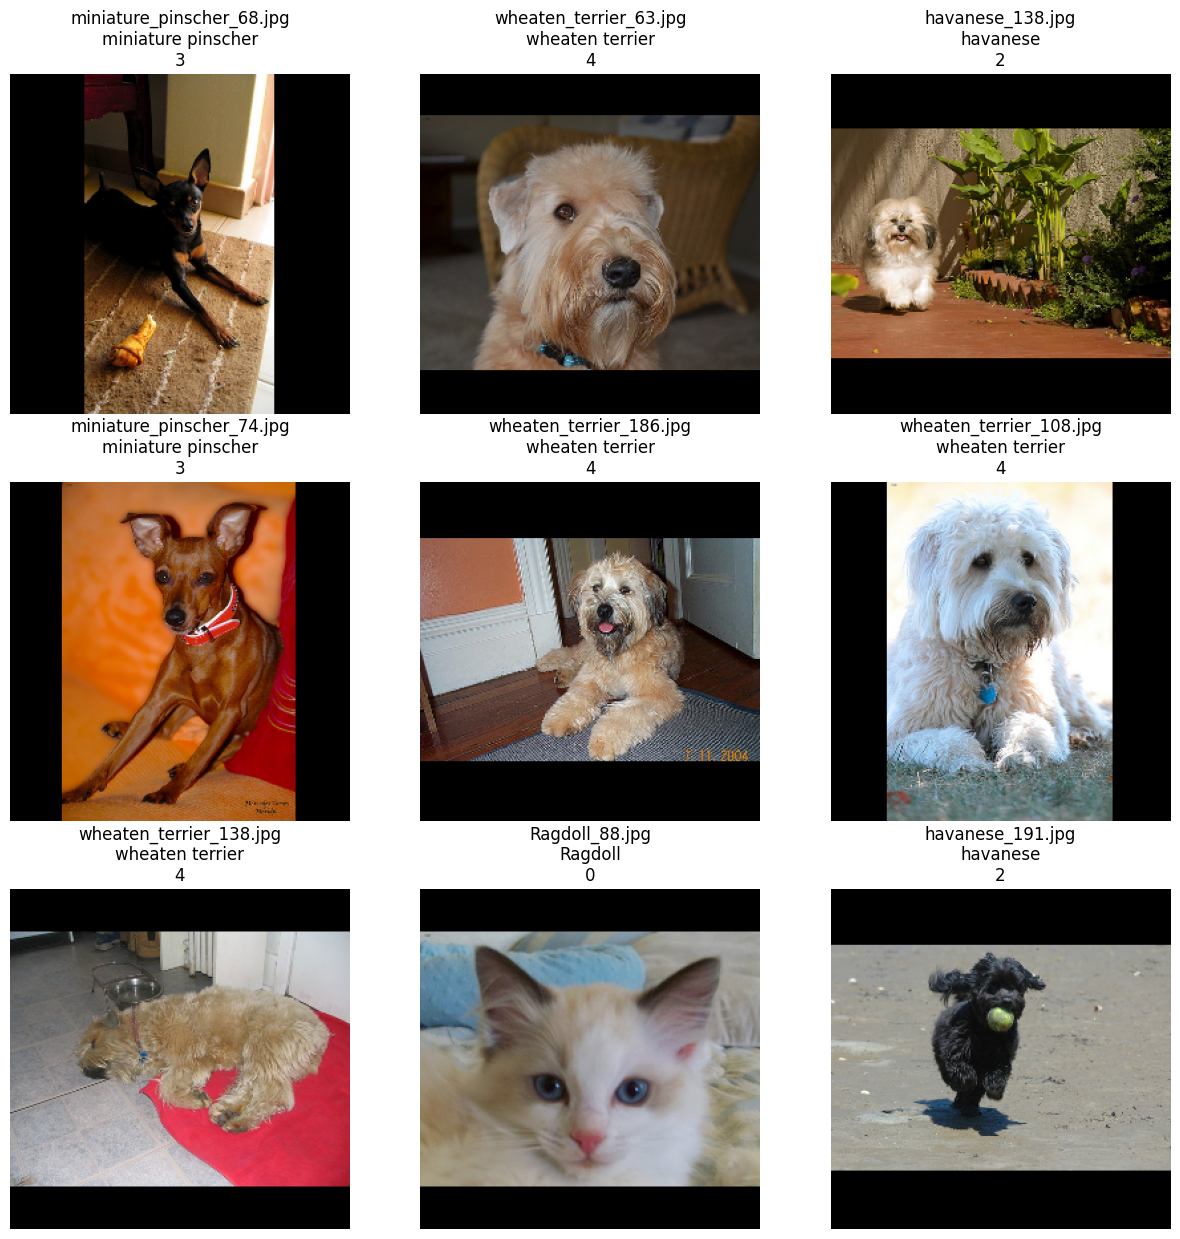

In [12]:
plt.subplots(nrows = 3, ncols = 3, figsize = (15, 15))

for i, imgIndex in enumerate(np.random.randint(0, len(imageNames), size = 9)):
  plt.subplot(3, 3, i + 1)
  plt.axis(False)
  plt.grid(False)
  plt.title(f'{imageNames[imgIndex]}\n{labels[imgIndex]}\n{labelsEncoded[imgIndex]}')
  plt.imshow(imageData[imgIndex])
plt.show()

In [13]:
imageData.max()

255

In [14]:
X_tv, X_test, y_tv, y_test = train_test_split(
    imageData, 
    labelsEncoded, 
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE, 
    stratify = labelsEncoded
    )

X_train, X_val, y_train, y_val = train_test_split(
    X_tv, 
    y_tv, 
    test_size = VAL_SIZE, 
    random_state = RANDOM_STATE, 
    stratify = y_tv
    )

print(f'Training Data: {X_train.shape}')
print(f'Training Labels: {len(y_train)}')
print(f'\nValidation Data: {X_val.shape}')
print(f'Validation Labels: {len(y_val)}')
print(f'\nTesting Data: {X_test.shape}')
print(f'Testing Labels: {len(y_test)}')

Training Data: (810, 256, 256, 3)
Training Labels: 810

Validation Data: (90, 256, 256, 3)
Validation Labels: 90

Testing Data: (100, 256, 256, 3)
Testing Labels: 100


In [15]:
# float and normalization
X_train = X_train.astype('float32')
X_val = X_val.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_val /= 255
X_test /= 255
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

In [16]:
print(y_train.shape)

(810,)


In [17]:
model = Sequential([
    Conv2D(32, 5, padding='same', input_shape=(256, 256, 3)),
    Conv2D(32, 5, padding='same', activation=LeakyReLU(alpha=0.5)),
    MaxPooling2D(),
    Conv2D(64, 4, padding='same'),
    Conv2D(64, 4, padding='same', activation=LeakyReLU(alpha=0.5)),
    MaxPooling2D(),
    Conv2D(128, 3, padding='same'),
    Conv2D(128, 3, padding='same', activation=LeakyReLU(alpha=0.5)),
    MaxPooling2D(),
    Conv2D(256, 2, padding='same'),
    Conv2D(256, 2, padding='same', activation=LeakyReLU(alpha=0.5)),
    MaxPooling2D(),
    Flatten(),
    BatchNormalization(),
    Dropout(0.2),
    Dense(512, activation='sigmoid'),
    Dropout(0.2),
    Dense(256, activation='sigmoid'),
    Dropout(0.1),
    Dense(5, activation='softmax')
])

model.compile(optimizer = Adam(), 
              loss = 'sparse_categorical_crossentropy', 
              metrics = ['sparse_categorical_accuracy'])
 
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 32)      25632     
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 32)      0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 64)      32832     
                                                                 
 conv2d_3 (Conv2D)           (None, 128, 128, 64)      65600     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 64, 64, 64)        0         
 g2D)                                                   

In [18]:
earlyStop = EarlyStopping(monitor = 'val_loss', patience = 10, restore_best_weights = True)

In [19]:
history = model.fit(X_train, y_train, epochs=200,validation_data=(X_val, y_val),callbacks = [earlyStop])

Epoch 1/200
26/26 [==============================] - 144s 5s/step - loss: 1.5804 - sparse_categorical_accuracy: 0.2938 - val_loss: 1.8099 - val_sparse_categorical_accuracy: 0.2111
Epoch 2/200
26/26 [==============================] - 142s 5s/step - loss: 1.4993 - sparse_categorical_accuracy: 0.3605 - val_loss: 1.4918 - val_sparse_categorical_accuracy: 0.2778
Epoch 3/200
26/26 [==============================] - 142s 5s/step - loss: 1.3766 - sparse_categorical_accuracy: 0.3840 - val_loss: 1.9337 - val_sparse_categorical_accuracy: 0.2111
Epoch 4/200
26/26 [==============================] - 141s 5s/step - loss: 1.3340 - sparse_categorical_accuracy: 0.4395 - val_loss: 1.5483 - val_sparse_categorical_accuracy: 0.3333
Epoch 5/200
26/26 [==============================] - 141s 5s/step - loss: 1.3484 - sparse_categorical_accuracy: 0.3963 - val_loss: 1.6419 - val_sparse_categorical_accuracy: 0.2222
Epoch 6/200
26/26 [==============================] - 141s 5s/step - loss: 1.3123 - sparse_categorica

KeyboardInterrupt: 

In [ ]:
acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = history.epoch

plt.figure(figsize = (16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label = 'Training Accuracy')
plt.plot(epochs_range, val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)

print(f"Loss on Testing data: {test_loss}")
print(f"Accuracy on Testing data: {test_acc}")